In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import string

import nltk
from nltk.stem import PorterStemmer

In [42]:
data = pd.read_csv('data/Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [43]:
data.shape

(232074, 3)

In [44]:
df = data.sample(n=10000, random_state=42)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 74414 to 224640
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   text        10000 non-null  object
 2   class       10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


In [46]:
df['Unnamed: 0'].is_unique

True

In [47]:
df.drop(columns = 'Unnamed: 0',inplace=True)

In [48]:
df.head()

,text,class
74414,I Don't know?7? Months self harm free and the ...,suicide
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide
14043,I've honestly got no idea what to do anymore.I...,suicide
30673,Do you ever just cry? Like you just think abou...,non-suicide


In [49]:
df.isnull().sum()

text     0
class    0
dtype: int64

In [50]:
df.duplicated().sum()

0

class
non-suicide    5048
suicide        4952
Name: count, dtype: int64


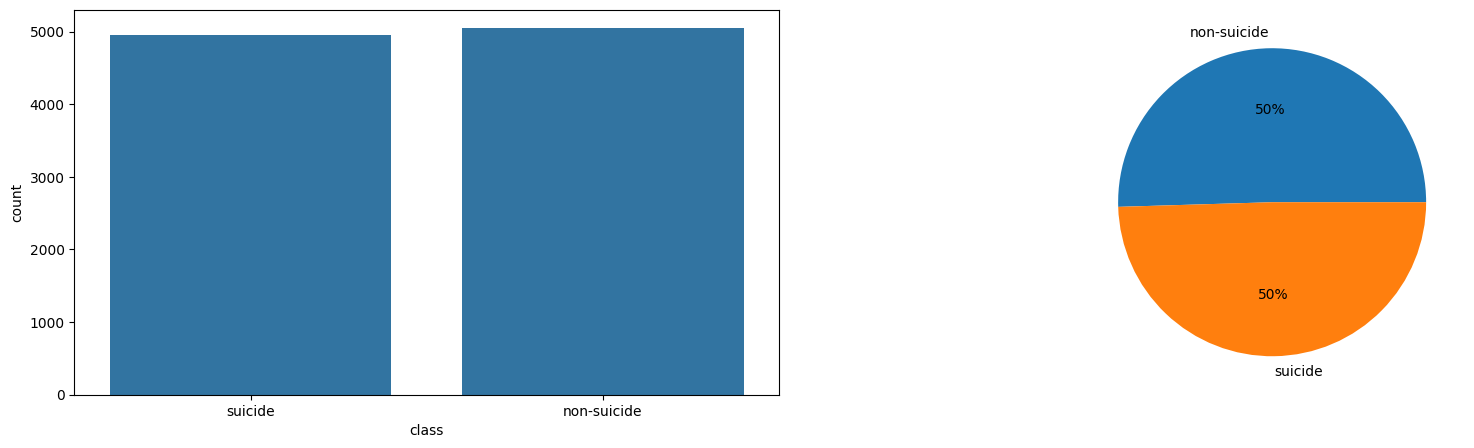

In [51]:
classCnt = df['class'].value_counts()
print(classCnt)

plt.figure(figsize=((20,5)))

plt.subplot(1,2,1)
sns.countplot(df,x='class')

plt.subplot(1,2,2)
plt.pie(classCnt,labels = classCnt.index,autopct='%.0f%%')

plt.show()

In [52]:
df['text']= df['text'].str.lower()

In [53]:
df['text'] = df['text'].str.replace(r'[^\w\s]+', '',regex = True)

In [54]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [55]:
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x))

In [56]:
ps = PorterStemmer()
df['text'] = df['text'].apply(lambda x : [ps.stem(i) for i in x])

In [57]:
df['text']=df['text'].apply(lambda x : ' '.join(x))

In [58]:
df.head()

,text,class
74414,dont know7 month self harm free urg get strong...,suicide
149516,start becom rich start compani becom 16 afford...,non-suicide
12484,poem haiku umegamedev hi hello hello stop fuck...,non-suicide
14043,ive honestli got idea anymoreit feel everyon f...,suicide
30673,ever cri like think unfair life cri cant cri e...,non-suicide


In [59]:
df.to_csv('file1.csv')

In [60]:
dfnew = pd.read_csv('file1.csv')
dfnew.head()

,Unnamed: 0,text,class
0,74414,dont know7 month self harm free urg get strong...,suicide
1,149516,start becom rich start compani becom 16 afford...,non-suicide
2,12484,poem haiku umegamedev hi hello hello stop fuck...,non-suicide
3,14043,ive honestli got idea anymoreit feel everyon f...,suicide
4,30673,ever cri like think unfair life cri cant cri e...,non-suicide


In [61]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   text        9999 non-null   object
 2   class       10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [62]:
ind = dfnew[dfnew['text'].isnull()].index

In [63]:
df.iloc[ind]

,text,class
102482,,suicide


In [64]:
dfnew.dropna(inplace=True)

In [65]:
x,y = dfnew['text'],dfnew['class']

In [66]:
vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x =  vectorizer.fit_transform(x).toarray()

In [67]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=5)

In [68]:
X_train.shape,X_test.shape

((6999, 1320), (3000, 1320))

In [69]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting = 'soft')
VotingClassifiers.fit(X_train, y_train)
print('Training score:',VotingClassifiers.score(X_train, y_train))
print('Testing score:',VotingClassifiers.score(X_test,y_test))

Training score: 0.899271324474925
Testing score: 0.8753333333333333


              precision    recall  f1-score   support

 non-suicide       0.88      0.88      0.88      1542
     suicide       0.87      0.87      0.87      1458

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



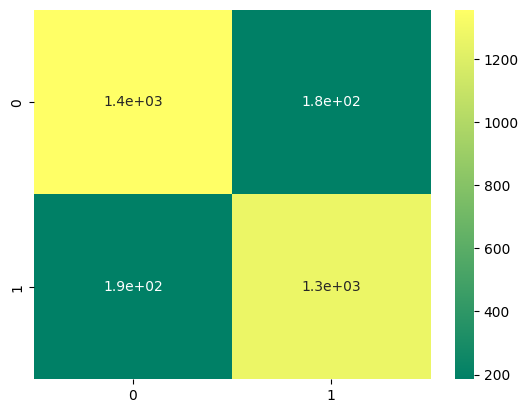

In [70]:
y_act=y_test
y_pred=VotingClassifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='summer')
print(classification_report(y_act,y_pred))

In [71]:
classifiers = RandomizedSearchCV(RandomForestClassifier(),{'n_estimators':[4,5],'criterion':['entropy'],
                                                      'max_depth':range(1,4),'min_samples_split':range(2,5)},random_state=12)
classifiers.fit(X_train, y_train)
print('Training score:',classifiers.score(X_train, y_train))
print('Testing score:',classifiers.score(X_test,y_test))
print(classifiers.best_estimator_)

Training score: 0.7583940562937562
Testing score: 0.758
RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_split=3,
                       n_estimators=5)


              precision    recall  f1-score   support

 non-suicide       0.74      0.82      0.78      1542
     suicide       0.79      0.69      0.73      1458

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.76      0.76      0.76      3000



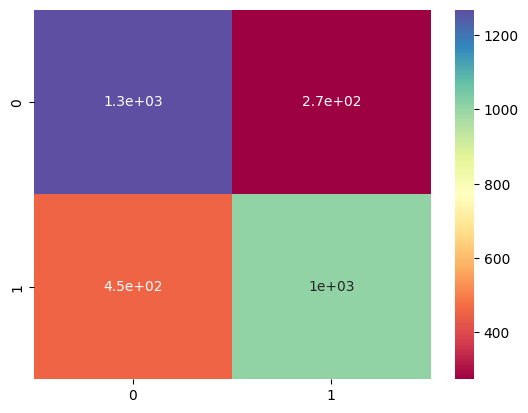

In [72]:
y_act=y_test
y_pred=classifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='Spectral')
print(classification_report(y_act,y_pred))

In [73]:
model2 = DecisionTreeClassifier(criterion='gini',splitter='random',min_samples_leaf=70,max_depth=4,random_state=0)
model2.fit(X_train, y_train)
print(model2.score(X_train, y_train))
print(model2.score(X_test,y_test))

0.7485355050721532
0.7526666666666667


              precision    recall  f1-score   support

 non-suicide       0.74      0.80      0.77      1542
     suicide       0.77      0.70      0.73      1458

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000



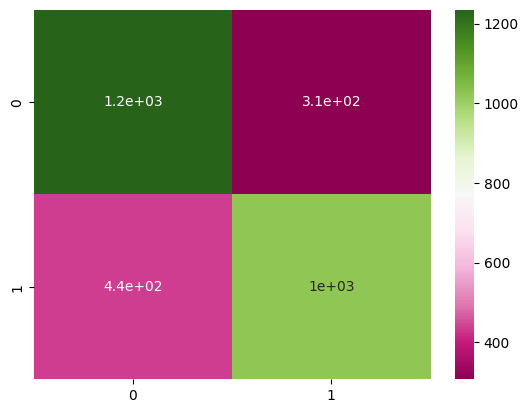

In [74]:
y_act=y_test
y_pred=model2.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='PiYG')
print(classification_report(y_act,y_pred))

In [75]:
model = RandomizedSearchCV(KNeighborsClassifier(),{'n_neighbors':[8],'metric':['manhattan','minkowski','cosine','tanimoto'],
                                                   'p':[1,2]},random_state=42,n_jobs=-1)
model.fit(X_train, y_train)
print('Training score:',model.score(X_train, y_train))
print('Testing score:',model.score(X_test,y_test))
print(model.best_estimator_)

C:\Users\Welcome\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Welcome\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Welcome\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, 

Training score: 0.8729818545506501
Testing score: 0.8526666666666667
KNeighborsClassifier(metric='cosine', n_neighbors=8, p=1)


              precision    recall  f1-score   support

 non-suicide       0.83      0.90      0.86      1542
     suicide       0.88      0.80      0.84      1458

    accuracy                           0.85      3000
   macro avg       0.86      0.85      0.85      3000
weighted avg       0.86      0.85      0.85      3000



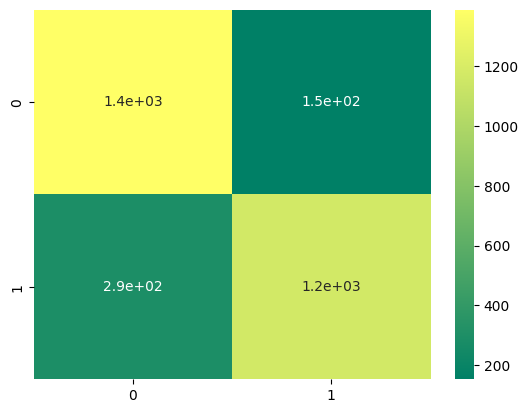

In [76]:
y_act = y_test
y_pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='summer')
print(classification_report(y_act,y_pred))